In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Custom Braille Dataset
class BrailleDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        valid_folders = [
            folder for folder in sorted(os.listdir(root_dir))
            if not folder.startswith('.') and os.path.isdir(os.path.join(root_dir, folder))
        ]

        print("Valid folders and assigned labels:")
        for label, folder in enumerate(valid_folders):
            print(f"Label {label}: {folder}")
            folder_path = os.path.join(root_dir, folder)
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(folder_path, file), label))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
# Data transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and split dataset
dataset_path = 'dataset' 
full_dataset = BrailleDataset(dataset_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Valid folders and assigned labels:
Label 0: A
Label 1: B
Label 2: C
Label 3: D
Label 4: E
Label 5: F
Label 6: G
Label 7: H
Label 8: I
Label 9: J
Label 10: K
Label 11: L
Label 12: M
Label 13: N
Label 14: O
Label 15: P
Label 16: Q
Label 17: R
Label 18: S
Label 19: T
Label 20: U
Label 21: V
Label 22: W
Label 23: X
Label 24: Y
Label 25: Z


In [4]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Train + Evaluate function with EarlyStopping, F1, Confusion Matrix
def train_and_evaluate(model_fn, model_name, patience=3, max_epochs=30, save_dir='saved_models'):
    print(f"\n=== Training {model_name} ===")
    model = model_fn(pretrained=True)

    if 'resnet' in model_name or 'resnext' in model_name:
        model.fc = nn.Linear(model.fc.in_features, 26)
    elif 'vgg' in model_name:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 26)
    elif 'mobilenet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 26)
    elif 'efficientnet' in model_name:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 26)
    elif 'densenet' in model_name:
        model.classifier = nn.Linear(model.classifier.in_features, 26)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0
    best_epoch = 0
    epochs_no_improve = 0
    best_model_state = None

    train_acc_list = []
    val_acc_list = []
    val_f1_list = []

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_acc_list.append(train_acc)

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1).cpu()
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        val_acc_list.append(val_acc)
        val_f1_list.append(f1)

        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, "
              f"Train_Acc={train_acc:.4f}, Val_Acc={val_acc:.4f}, F1={f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_model_state = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_state, os.path.join(save_dir, f'{model_name}_best.pt'))
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"🛑 Early stopping triggered at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)
    print(f"\n✅ Best Epoch: {best_epoch+1} | Best Val Accuracy: {best_val_acc:.4f}")

    # Plot accuracy & F1 curve
    epochs_range = range(1, len(train_acc_list) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, train_acc_list, label='Train Acc')
    plt.plot(epochs_range, val_acc_list, label='Val Acc')
    plt.plot(epochs_range, val_f1_list, label='Val F1-score')
    plt.axvline(x=best_epoch + 1, color='green', linestyle='--', label='Best Epoch')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"Accuracy & F1-score: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[chr(65+i) for i in range(26)])
    disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

    return best_val_acc



=== Training resnet18 ===


F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=2.3949, Train_Acc=0.4335, Val_Acc=0.7308, F1=0.7263
Epoch 2: Loss=0.8098, Train_Acc=0.9143, Val_Acc=0.9327, F1=0.9339
Epoch 3: Loss=0.2661, Train_Acc=0.9920, Val_Acc=0.9776, F1=0.9777
Epoch 4: Loss=0.1086, Train_Acc=1.0000, Val_Acc=0.9904, F1=0.9904
Epoch 5: Loss=0.0535, Train_Acc=1.0000, Val_Acc=0.9872, F1=0.9872
Epoch 6: Loss=0.0362, Train_Acc=1.0000, Val_Acc=0.9936, F1=0.9935
Epoch 7: Loss=0.0248, Train_Acc=1.0000, Val_Acc=0.9936, F1=0.9935
Epoch 8: Loss=0.0177, Train_Acc=1.0000, Val_Acc=0.9936, F1=0.9935
Epoch 9: Loss=0.0142, Train_Acc=1.0000, Val_Acc=0.9968, F1=0.9968
Epoch 10: Loss=0.0127, Train_Acc=1.0000, Val_Acc=0.9936, F1=0.9935
Epoch 11: Loss=0.0113, Train_Acc=1.0000, Val_Acc=0.9968, F1=0.9968
Epoch 12: Loss=0.0102, Train_Acc=1.0000, Val_Acc=0.9968, F1=0.9968
🛑 Early stopping triggered at epoch 12

✅ Best Epoch: 9 | Best Val Accuracy: 0.9968


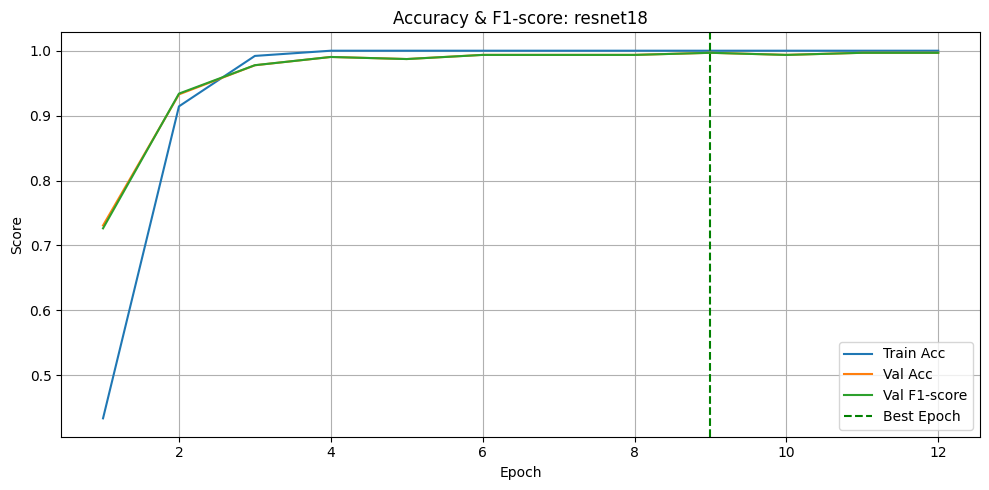

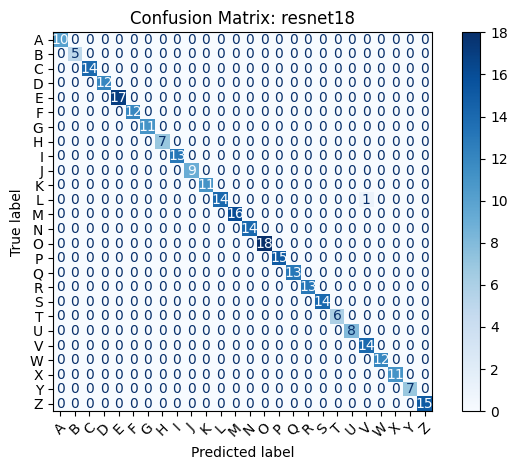

Final accuracy: 0.9967948717948718


In [6]:
# Run training
acc = train_and_evaluate(models.resnet18, "resnet18")
print("Final accuracy:", acc)


=== Training vgg16 ===


F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=3.1229, Train_Acc=0.0809, Val_Acc=0.4423, F1=0.4340
Epoch 2: Loss=1.2900, Train_Acc=0.5994, Val_Acc=0.8494, F1=0.8501
Epoch 3: Loss=0.5541, Train_Acc=0.8237, Val_Acc=0.8974, F1=0.8962
Epoch 4: Loss=0.2802, Train_Acc=0.9135, Val_Acc=0.9679, F1=0.9673
Epoch 5: Loss=0.1466, Train_Acc=0.9559, Val_Acc=0.9167, F1=0.9186
Epoch 6: Loss=0.0624, Train_Acc=0.9800, Val_Acc=0.9904, F1=0.9906
Epoch 7: Loss=0.0962, Train_Acc=0.9704, Val_Acc=0.9744, F1=0.9749
Epoch 8: Loss=0.0758, Train_Acc=0.9768, Val_Acc=0.9679, F1=0.9677
Epoch 9: Loss=0.0354, Train_Acc=0.9896, Val_Acc=0.9744, F1=0.9746
🛑 Early stopping triggered at epoch 9

✅ Best Epoch: 6 | Best Val Accuracy: 0.9904


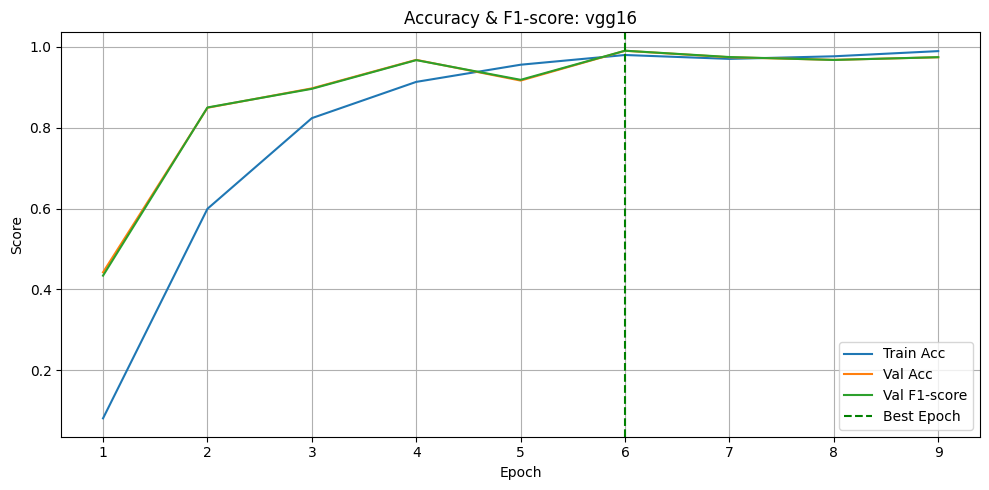

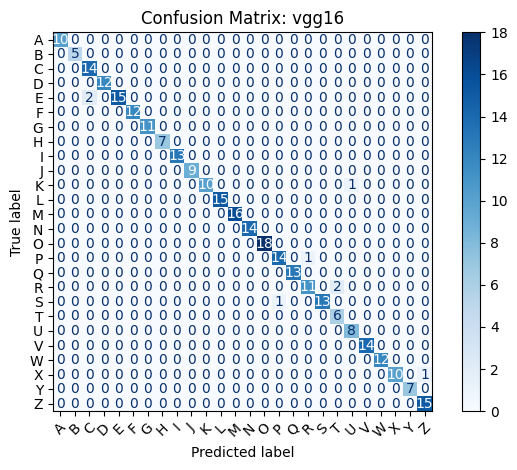

Final accuracy: 0.9903846153846154


In [8]:
# Run training
acc = train_and_evaluate(models.vgg16, "vgg16")
print("Final accuracy:", acc)


=== Training mobilenet_v2 ===


F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=2.9167, Train_Acc=0.2476, Val_Acc=0.4776, F1=0.4650
Epoch 2: Loss=1.7458, Train_Acc=0.6915, Val_Acc=0.8686, F1=0.8691
Epoch 3: Loss=0.9023, Train_Acc=0.8942, Val_Acc=0.9519, F1=0.9515
Epoch 4: Loss=0.4370, Train_Acc=0.9696, Val_Acc=0.9808, F1=0.9812
Epoch 5: Loss=0.2134, Train_Acc=0.9944, Val_Acc=1.0000, F1=1.0000
Epoch 6: Loss=0.1196, Train_Acc=0.9992, Val_Acc=0.9936, F1=0.9937
Epoch 7: Loss=0.0726, Train_Acc=0.9992, Val_Acc=1.0000, F1=1.0000
Epoch 8: Loss=0.0540, Train_Acc=1.0000, Val_Acc=1.0000, F1=1.0000
🛑 Early stopping triggered at epoch 8

✅ Best Epoch: 5 | Best Val Accuracy: 1.0000


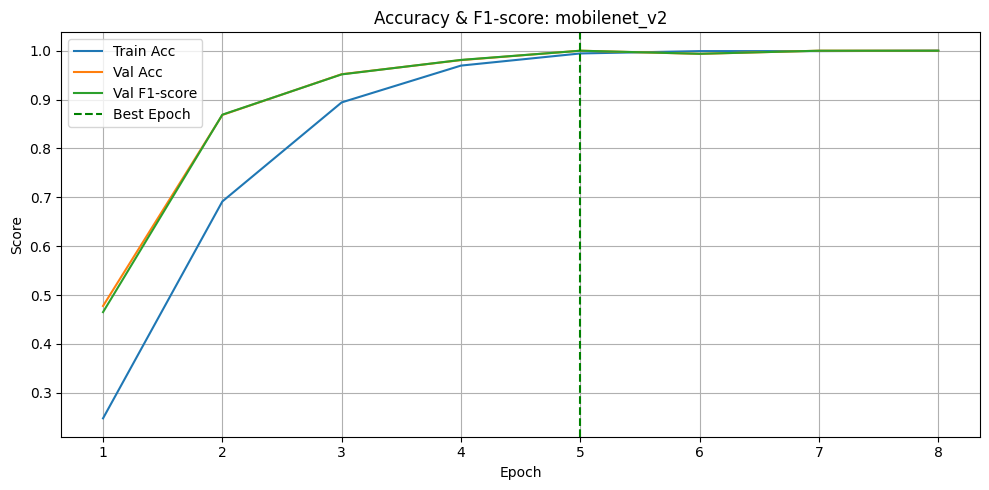

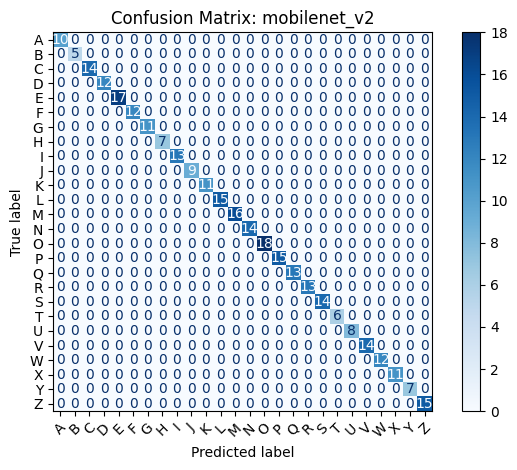

Final accuracy: 1.0


In [9]:
# Run training
acc = train_and_evaluate(models.mobilenet_v2, "mobilenet_v2")
print("Final accuracy:", acc)


=== Training efficientnet_b0 ===


F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=3.1629, Train_Acc=0.1354, Val_Acc=0.1090, F1=0.0885
Epoch 2: Loss=2.7226, Train_Acc=0.4647, Val_Acc=0.4840, F1=0.4758
Epoch 3: Loss=2.1335, Train_Acc=0.6867, Val_Acc=0.7179, F1=0.7086
Epoch 4: Loss=1.4517, Train_Acc=0.8317, Val_Acc=0.8590, F1=0.8581
Epoch 5: Loss=0.8278, Train_Acc=0.9215, Val_Acc=0.9487, F1=0.9497
Epoch 6: Loss=0.4328, Train_Acc=0.9671, Val_Acc=0.9647, F1=0.9648
Epoch 7: Loss=0.2454, Train_Acc=0.9816, Val_Acc=0.9776, F1=0.9780
Epoch 8: Loss=0.1664, Train_Acc=0.9888, Val_Acc=0.9808, F1=0.9811
Epoch 9: Loss=0.1173, Train_Acc=0.9912, Val_Acc=0.9904, F1=0.9904
Epoch 10: Loss=0.0884, Train_Acc=0.9952, Val_Acc=0.9872, F1=0.9874
Epoch 11: Loss=0.0683, Train_Acc=0.9968, Val_Acc=0.9968, F1=0.9968
Epoch 12: Loss=0.0570, Train_Acc=0.9944, Val_Acc=0.9968, F1=0.9969
Epoch 13: Loss=0.0502, Train_Acc=0.9960, Val_Acc=0.9904, F1=0.9905
Epoch 14: Loss=0.0417, Train_Acc=0.9960, Val_Acc=0.9904, F1=0.9904
🛑 Early stopping triggered at epoch 14

✅ Best Epoch: 11 | Best Val Acc

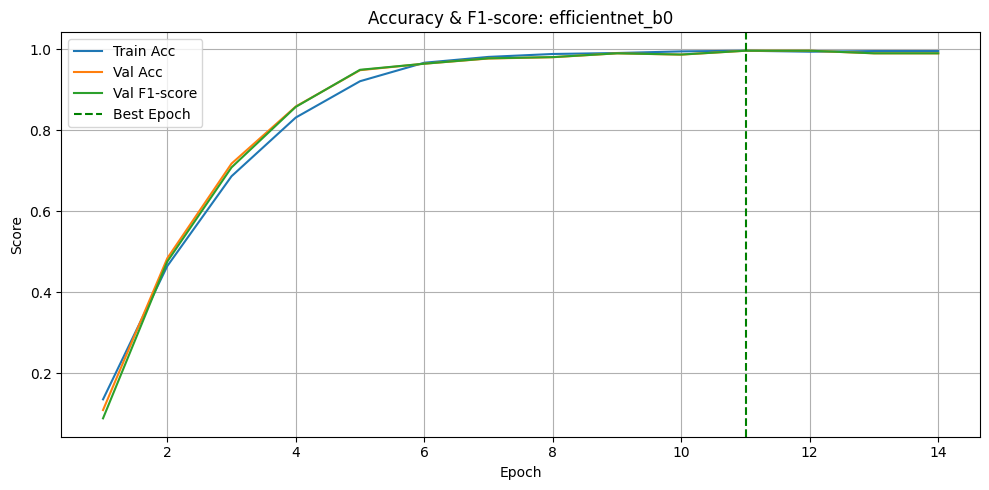

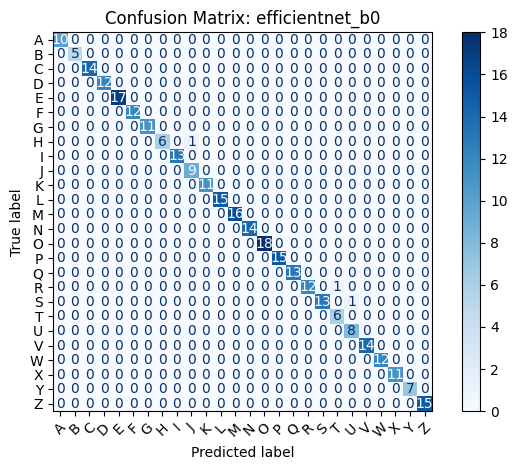

Final accuracy: 0.9967948717948718


In [10]:
# Run training
acc = train_and_evaluate(models.efficientnet_b0, "efficientnet_b0")
print("Final accuracy:", acc)


=== Training densenet121 ===


F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\anaconda\envs\homework\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=2.8590, Train_Acc=0.2989, Val_Acc=0.5160, F1=0.5165
Epoch 2: Loss=1.6649, Train_Acc=0.8005, Val_Acc=0.7596, F1=0.7640
Epoch 3: Loss=0.8150, Train_Acc=0.9607, Val_Acc=0.8974, F1=0.8989
Epoch 4: Loss=0.3673, Train_Acc=0.9888, Val_Acc=0.9776, F1=0.9774
Epoch 5: Loss=0.1700, Train_Acc=0.9992, Val_Acc=0.9808, F1=0.9807
Epoch 6: Loss=0.1047, Train_Acc=0.9992, Val_Acc=0.9872, F1=0.9871
Epoch 7: Loss=0.0624, Train_Acc=1.0000, Val_Acc=0.9968, F1=0.9968
Epoch 8: Loss=0.0432, Train_Acc=1.0000, Val_Acc=0.9936, F1=0.9935
Epoch 9: Loss=0.0355, Train_Acc=1.0000, Val_Acc=1.0000, F1=1.0000
Epoch 10: Loss=0.0296, Train_Acc=1.0000, Val_Acc=1.0000, F1=1.0000
Epoch 11: Loss=0.0237, Train_Acc=1.0000, Val_Acc=0.9968, F1=0.9968
Epoch 12: Loss=0.0186, Train_Acc=1.0000, Val_Acc=1.0000, F1=1.0000
🛑 Early stopping triggered at epoch 12

✅ Best Epoch: 9 | Best Val Accuracy: 1.0000


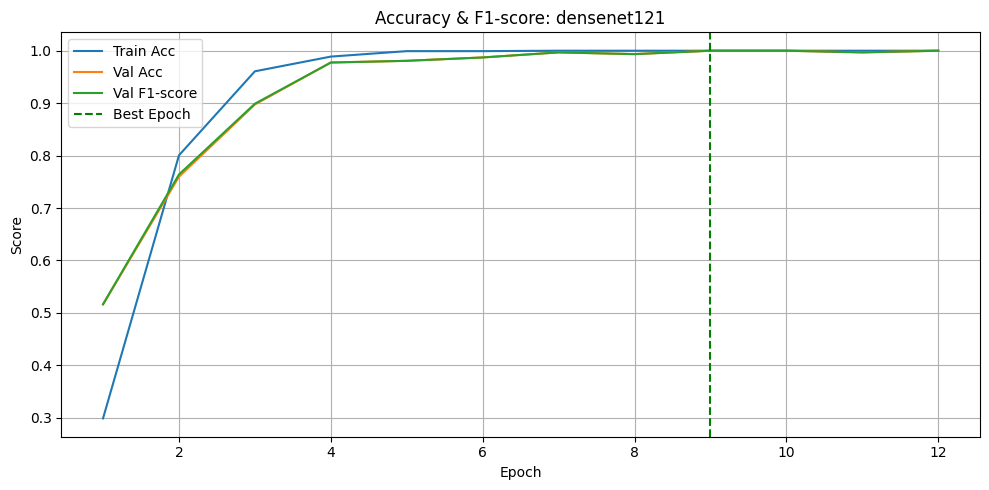

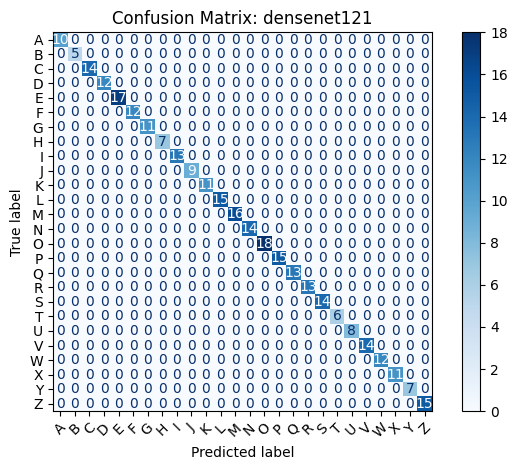

Final accuracy: 1.0


In [11]:
# Run training
acc = train_and_evaluate(models.densenet121, "densenet121")
print("Final accuracy:", acc)

| Model's Name         | Best Epoch | Val Accuracy  |
|------------------|------------|-------------|
| ResNet18         | 9          | 0.9968      |
| VGG16            | 6          | 0.9904      |
| MobileNetV2      | 5          | **1.0000**  |
| EfficientNet_B0  | 11         | 0.9968      |
| DenseNet121      | 9          | **1.0000**  |

Therefore, we have two models that achieve the best value, and there is no sign showing that they are overfitting because both of these reach an optimal value at an early Epoch. We can choose one of these models for the testing in nest step.